In [1]:
from datetime import datetime, timedelta
from collections import Counter

import numpy as np
np.random.seed(4242)

import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
from sklearn.metrics import (
    f1_score, recall_score, roc_auc_score,
    precision_recall_curve, average_precision_score,
    roc_curve)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold

import lightgbm as lgb

import tqdm

from tsfresh.feature_extraction import MinimalFCParameters
from tsfresh import extract_features

In [2]:
df = pd.read_csv(
    '../../data/dataset_utf.csv',
    parse_dates=['date']
)

In [3]:
df_clean = df[
    (datetime(2017, 1, 11, 0, 0, 0) <= df.date) &
    ~(
        (datetime(2017, 4, 15, 0, 0, 0) <= df.date) &
        (df.date <= datetime(2017, 4, 15, 23, 59, 50))
    ) &
    ~(
        (datetime(2017, 8, 1, 0, 0, 0) <= df.date) &
        (df.date <= datetime(2017, 8, 1, 23, 59, 50))
    ) &
    ~(
        (datetime(2017, 10, 9, 0, 0, 0) <= df.date) &
        (df.date <= datetime(2017, 10, 9, 23, 59, 50))
    ) &
    (df.date <= datetime(2017, 12, 31, 23, 59, 50))
]
df_clean

date  RF.21304.Ток...213MII904A  \
86399   2017-01-11 00:00:00                        5.0   
86400   2017-01-11 00:00:10                        5.0   
86401   2017-01-11 00:00:20                        5.0   
86402   2017-01-11 00:00:30                        5.1   
86403   2017-01-11 00:00:40                        5.0   
86404   2017-01-11 00:00:50                        4.9   
86405   2017-01-11 00:01:00                        5.1   
86406   2017-01-11 00:01:10                        5.0   
86407   2017-01-11 00:01:20                        5.0   
86408   2017-01-11 00:01:30                        4.9   
86409   2017-01-11 00:01:40                        5.0   
86410   2017-01-11 00:01:50                        5.0   
86411   2017-01-11 00:02:00                        5.0   
86412   2017-01-11 00:02:10                        5.1   
86413   2017-01-11 00:02:20                        5.1   
86414   2017-01-11 00:02:30                        5.0   
86415   2017-01-11 00:02:40                        5.1   
86416   2017-01-11 00:02:50                        5.1   
86417   2017-01-11 00:03:00                        4.9   
86418   2017-01-11 00:03:10                        5.1   
86419   2017-01-11 00:03:20                        5.0   
86420   2017-01-11 00:03:30                        5.0   
86421   2017-01-11 00:03:40                        4.9   
86422   2017-01-11 00:03:50                        5.0   
86423   2017-01-11 00:04:00                        5.1   
86424   2017-01-11 00:04:10                        5.0   
86425   2017-01-11 00:04:20                        5.0   
86426   2017-01-11 00:04:30                        5.1   
86427   2017-01-11 00:04:40                        5.0   
86428   2017-01-11 00:04:50                        5.0   
...                     ...                        ...   
3153569 2017-12-31 23:55:00                        5.0   
3153570 2017-12-31 23:55:10                        5.0   
3153571 2017-12-31 23:55:20                        4.9   
3153572 2017-12-31 23:55:30                        5.0   
3153573 2017-12-31 23:55:40                        5.0   
3153574 2017-12-31 23:55:50                        5.0   
3153575 2017-12-31 23:56:00                        4.9   
3153576 2017-12-31 23:56:10                        4.9   
3153577 2017-12-31 23:56:20                        5.0   
3153578 2017-12-31 23:56:30                        5.0   
3153579 2017-12-31 23:56:40                        5.0   
3153580 2017-12-31 23:56:50                        5.0   
3153581 2017-12-31 23:57:00                        4.9   
3153582 2017-12-31 23:57:10                        5.0   
3153583 2017-12-31 23:57:20                        5.0   
3153584 2017-12-31 23:57:30                        4.9   
3153585 2017-12-31 23:57:40                        5.0   
3153586 2017-12-31 23:57:50                        5.0   
3153587 2017-12-31 23:58:00                        5.0   
3153588 2017-12-31 23:58:10                        4.9   
3153589 2017-12-31 23:58:20                        4.8   
3153590 2017-12-31 23:58:30                        5.0   
3153591 2017-12-31 23:58:40                        4.9   
3153592 2017-12-31 23:58:50                        5.0   
3153593 2017-12-31 23:59:00                        4.9   
3153594 2017-12-31 23:59:10                        4.9   
3153595 2017-12-31 23:59:20                        4.9   
3153596 2017-12-31 23:59:30                        4.9   
3153597 2017-12-31 23:59:40                        4.9   
3153598 2017-12-31 23:59:50                        4.9   

         S.C.ВПУСК.ПП.ДАВЛ...214PI226AA  S.C.ВПУСК.ПП.ДАВЛ...214PI226AB  \
86399                          9.710000                        9.510000   
86400                          9.889999                        9.670000   
86401                          9.920000                        9.690000   
86402                          9.900000                        9.670000   
86403                          9.889999            

In [4]:
# Counter(df_clean.date[df_clean.isnull().any(axis=1)].map(
#     lambda x: (x - datetime(2017, 1, 1, 0, 0, 0)).total_seconds() // 86400))

In [5]:
stops = pd.read_csv('../../data/stops.csv', parse_dates=['date'])
stops = pd.concat([
    pd.read_csv('../../data/good_stops.csv', parse_dates=['date'], index_col=0).date,
    stops.date[stops.type == 'vibrosito']
])
stops.sort_values(inplace=True)
stops = stops.reset_index()

In [6]:
def make_range(df, stop_dt, to_left, to_right):
    left = stop_dt - timedelta(minutes=to_left)
    right = stop_dt + timedelta(minutes=to_right)
    return (left <= df.date) & (df.date <= right)

df_no_stops = df_clean.copy()
for stop_dt in stops.date:
    df_no_stops = df_no_stops[~make_range(df_no_stops, stop_dt, to_left=480, to_right=180)]

In [7]:
def make_false(df_no_stops, minutes):
    random_work = np.random.choice(np.arange(minutes * 6, df_no_stops.shape[0]), 10000)
    dfs = []
    ids = []
    
    for work in tqdm.tqdm_notebook(random_work):
        stop_dt = df_no_stops.iloc[work]['date']
        df = df_no_stops[make_range(df_no_stops, stop_dt, to_left=minutes, to_right=0)].copy()
        if not df.shape[0]:
            continue
        id = stop_dt.to_datetime64().astype(int)
        df['id'] = id
        ids.append(id)
        dfs.append(df)
    
    y = pd.Series(0, index=ids)
    return pd.concat(dfs), y

In [8]:
def make_true(df_with_stops, stops, minutes_before, minutes_in):
    dfs = []
    ids = []

    for stop_dt in tqdm.tqdm_notebook(stops.date[stops.date < datetime(2018, 1, 1, 0, 0, 0)]):
        dts = df_with_stops.date[df_with_stops.date]
        df = df_with_stops[make_range(df_with_stops, stop_dt, to_left=minutes, to_right=0)].copy()
        if not df.shape[0]:
            continue
        id = stop_dt.to_datetime64().astype(int)
        df['id'] = id
        ids.append(id)
        dfs.append(df)
        
    y = pd.Series(1, index=ids)
    return pd.concat(dfs), y

In [9]:
def make_train_val(X, y):
    skf = StratifiedKFold(n_splits=3, shuffle=True)
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        yield X_train, y_train, X_test, y_test

In [17]:
MAX_ROUNDS = 125
params = {
    'num_leaves': 2**5 - 1,
    'objective': 'binary',
    'max_depth': 8,
    'min_data_in_leaf': 50,
    'learning_rate': 0.05,
    'feature_fraction': 0.75,
    'bagging_fraction': 0.75,
    'bagging_freq': 1,
    'metric': 'binary',
    'num_threads': 4
}
    
def train(X_train, y_train):
    dtrain = lgb.Dataset(
        X_train, label=y_train,
        categorical_feature=[],
    )
    bst = lgb.train(
        params, dtrain, num_boost_round=MAX_ROUNDS,
        valid_sets=[dtrain], early_stopping_rounds=100, verbose_eval=50
    )
    
    return bst

In [13]:
def train_and_test(X_train, y_train, X_val, y_val):
    dval = lgb.Dataset(
        X_val, label=y_val, reference=dtrain,
        categorical_feature=[])
    
    bst = train(X_train, y_train)
    
    predicted = bst.predict(X_val, num_iteration=bst.best_iteration or MAX_ROUNDS)
    
    return predicted

In [ ]:
minutes = 60

Feature Extraction: 100%|██████████| 80/80 [01:07<00:00,  1.18it/s]
/usr/local/lib/python3.5/dist-packages/lightgbm/basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 100 rounds.
[50]	training's binary_logloss: 0.05123	valid_1's binary_logloss: 0.0534736
[100]	training's binary_logloss: 0.00870818	valid_1's binary_logloss: 0.0167956
[150]	training's binary_logloss: 0.00153895	valid_1's binary_logloss: 0.0162077
[200]	training's binary_logloss: 0.000346692	valid_1's binary_logloss: 0.0195433
Early stopping, best iteration is:
[126]	training's binary_logloss: 0.00351893	valid_1's binary_logloss: 0.0153017


/usr/local/lib/python3.5/dist-packages/lightgbm/basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 100 rounds.
[50]	training's binary_logloss: 0.0516324	valid_1's binary_logloss: 0.053934
[100]	training's binary_logloss: 0.00886169	valid_1's binary_logloss: 0.0166793
[150]	training's binary_logloss: 0.00164919	valid_1's binary_logloss: 0.0157854
[200]	training's binary_logloss: 0.000564067	valid_1's binary_logloss: 0.0197553
Early stopping, best iteration is:
[125]	training's binary_logloss: 0.00377253	valid_1's binary_logloss: 0.0146532


/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.5/dist-packages/lightgbm/basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 100 rounds.
[50]	training's binary_logloss: 0.0513326	valid_1's binary_logloss: 0.0540295
[100]	training's binary_logloss: 0.00777623	valid_1's binary_logloss: 0.020029
[150]	training's binary_logloss: 0.0012308	valid_1's binary_logloss: 0.0208634
[200]	training's binary_logloss: 0.000282634	valid_1's binary_logloss: 0.0263737
Early stopping, best iteration is:
[117]	training's binary_logloss: 0.00408111	valid_1's binary_logloss: 0.0190565
F1:      [0.4, 0.0, 0.0]
Recall:  [0.25, 0.0, 0.0]
ROC-AUC: [0.8945062099358975, 0.9538623384430418, 0.6913408202858158]
Mean F1:      0.13333333333333333
Mean recall:  0.08333333333333333
Mean roc-auc: 0.8465697895549184


/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


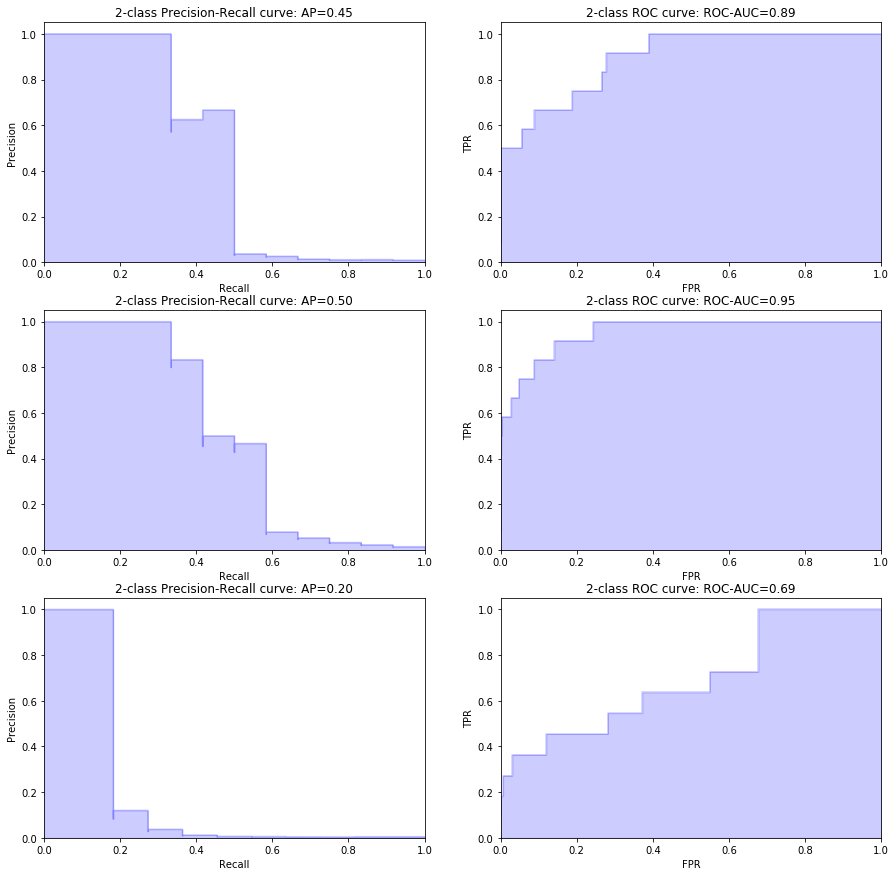

In [11]:
X_false, y_false = make_false(df_no_stops)

X_true, y_true = make_true(df_clean, stops)

X = pd.concat([X_false, X_true])
y = pd.concat([y_false, y_true])

features_extracted = extract_features(
    X,
    column_sort='date',
    column_id='id',
    default_fc_parameters=MinimalFCParameters()
)

# fix sampling in y_false
y = y.groupby(level=0).sum()

features_extracted.sort_index(inplace=True)
y.sort_index(inplace=True)

recalls = []
f_scores = []
roc_auc_scores = []

f, axarr = plt.subplots(3, 2, figsize=(15, 15))

for i, (X_train, y_train, X_val, y_val) in enumerate(make_train_val(features_extracted.values, y.values)):
    predicted = train_and_test(X_train, y_train, X_val, y_val)
    roc_auc_scores.append(roc_auc_score(y_val, predicted))

    precision, recall, _ = precision_recall_curve(y_val, predicted)

    axarr[i, 0].step(recall, precision, color='b', alpha=0.2,
             where='post')
    axarr[i, 0].fill_between(recall, precision, step='post', alpha=0.2,
                     color='b')

    axarr[i, 0].set_xlabel('Recall')
    axarr[i, 0].set_ylabel('Precision')
    axarr[i, 0].set_ylim([0.0, 1.05])
    axarr[i, 0].set_xlim([0.0, 1.0])
    axarr[i, 0].set_title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
              average_precision_score(y_val, predicted)))

    fpr, tpr, _ = roc_curve(y_val, predicted)

    axarr[i, 1].step(fpr, tpr, color='b', alpha=0.2,
             where='post')
    axarr[i, 1].fill_between(fpr, tpr, step='post', alpha=0.2,
                     color='b')

    axarr[i, 1].set_xlabel('FPR')
    axarr[i, 1].set_ylabel('TPR')
    axarr[i, 1].set_ylim([0.0, 1.05])
    axarr[i, 1].set_xlim([0.0, 1.0])
    axarr[i, 1].set_title('2-class ROC curve: ROC-AUC={0:0.2f}'.format(
              roc_auc_score(y_val, predicted)))

    predicted = (predicted > 0.5).astype(np.int32)
    f_scores.append(f1_score(y_val, predicted.astype(np.bool)))
    recalls.append(recall_score(y_val, predicted.astype(np.bool)))

print("F1:     ", f_scores)
print("Recall: ", recalls)
print("ROC-AUC:", roc_auc_scores)
print('Mean F1:     ', np.mean(f_scores))
print('Mean recall: ', np.mean(recalls))
print('Mean roc-auc:', np.mean(roc_auc_scores))

In [18]:
# X_false, y_false = make_false(df_no_stops)

# X_true, y_true = make_true(df_clean, stops)

# X = pd.concat([X_false, X_true])
# y = pd.concat([y_false, y_true])

# features_extracted = extract_features(
#     X,
#     column_sort='date',
#     column_id='id',
#     default_fc_parameters=MinimalFCParameters()
# )

# # fix sampling in y_false
# y = y.groupby(level=0).sum()

# features_extracted.sort_index(inplace=True)
# y.sort_index(inplace=True)

recalls = []
f_scores = []
roc_auc_scores = []

bst = train(features_extracted.values, y.values)
bst.predict(X_val, num_iteration=bst.best_iteration or MAX_ROUNDS)

/usr/local/lib/python3.5/dist-packages/lightgbm/basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 100 rounds.
[50]	training's binary_logloss: 0.0511968
[100]	training's binary_logloss: 0.00806448
Did not meet early stopping. Best iteration is:
[125]	training's binary_logloss: 0.00335734


array([0.00196629, 0.00131248, 0.00589557, ..., 0.00353596, 0.00134315,
       0.00123559])

In [19]:
bst.save_model('model.bin')

In [35]:
model = lgb.Booster(model_file='model.bin')

def predict(model, data):
    X = data.copy()
    X['id'] = 0
    features_extracted = extract_features(
        X,
        column_sort='date',
        column_id='id',
        default_fc_parameters=MinimalFCParameters(),
        disable_progressbar=True
    )
    
    pred = bst.predict(features_extracted.values, num_iteration=bst.best_iteration or MAX_ROUNDS)
    return pred[0]

predict(model, df_clean[100500:100500+6*30])

0.001602577009464638